# Exercise 2

In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Bootstrap - Reconstructing variance

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from franke_function import FrankeFunction as Fr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm # progressbar

#sk-learn linear regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# my own library
from regression import OLS


x = np.linspace(0, 1, 50) 
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

poly = 16
n_bootstraps = 10
MSE_test_list = [] 
MSE_train_list = []
predict_train_list = []
betas_list = []
predict_train_skl_list = []

#noise = np.random.randn(x.shape[0], x.shape[1])
#z = Fr(x, y) + noise*0.18 #multiply with degree of noice. 1*var_noise = 0.18

z = Fr(x, y)
noise = np.var(z)*np.random.normal(size=z.shape)
z += noise*5

x_cent =  ((x - np.mean(x))/np.mean(x)).reshape(-1, 1)  
y_cent =  ((y - np.mean(y))/np.mean(y)).reshape(-1, 1)  
z_cent =  ((z - np.mean(z))/np.mean(z)).reshape(-1, 1)

xy_cent_train, xy_cent_test, z_cent_train, z_cent_test = train_test_split(np.hstack([x_cent, y_cent]),
                                                                        z_cent, test_size=0.2)
for n in tqdm.tqdm(range(n_bootstraps)): 
    #print("Bootstrap number: " + str(n+1) + '/' + str(n_bootstraps))
    MSE_test = []
    MSE_train = []
    predict_train = []
    predict_train_skl = []
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)]) 
    
    #draw n samples from train set
    n = z_cent_train.size 
    samples_nr = np.random.randint(0,n,n)
    xy_samp = xy_cent_train[samples_nr, :]
    z_samp = z_cent_train[samples_nr, :]
    
    # polynomial fit to bootstrap samples
    for poly_deg in range(1, poly + 1):
        # fit own model
        model = OLS(xy_samp[:, 0].ravel(), xy_samp[:, 1].ravel(), z_samp.ravel(), poly_deg)
        
        #SKlearn
        model_skl = make_pipeline(PolynomialFeatures(degree=poly_deg), LinearRegression(fit_intercept=False))
        
        #calculate interesting numbers
        MSE_test.append(model.MSE(xy_cent_test[:, 0], xy_cent_test[:, 1], z_cent_test.ravel())) 
        MSE_train.append(model.MSE(xy_samp[:, 0], xy_samp[:, 1], z_samp.ravel())) # orig model.
        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(model.beta_OLS.ravel()) 
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2): -1] = np.nan
        predict_train.append(model.predict(xy_samp[:, 0], xy_samp[:, 1]).ravel())# predicted model
        
        #SKlearn
        predict_train_skl.append(model_skl.fit(xy_samp, z_samp.reshape(-1, 1)).predict(xy_samp).ravel())

    # store all values for averaging
    MSE_test_list.append(MSE_test) 
    MSE_train_list.append(MSE_train)
    predict_train_list.append(predict_train)
    betas_list.append(beta_poly) 
    predict_train_skl_list.append(predict_train_skl)
    
MSE_test_list = np.array(MSE_test_list)
MSE_train_list = np.array(MSE_train_list)
predict_train_list = np.array(predict_train_list)
predict_train_skl_list = np.array(predict_train_skl_list)
betas_list = np.array(betas_list, dtype=object)

#study average values
test_pol_avrg = np.mean(MSE_test_list, axis=0) 
train_pol_avrg = np.mean(MSE_train_list, axis=0)
predict_train_var = np.mean(np.var(predict_train_list, axis=0), axis=1) # mean( var( bootstrap attempts ))
mean_betas = np.mean(betas_list, axis=0) 
var_betas = np.var(betas_list, axis=0)

predict_train_var_skl = np.mean(np.var(predict_train_skl_list, axis=0), axis=1) # mean( var( bootstrap attempts ))

100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


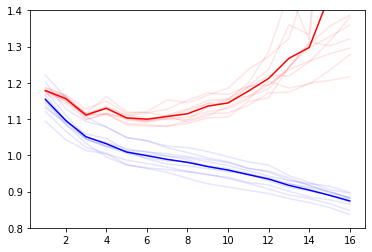

In [79]:
for i in range(len(MSE_test_list)):
    plt.plot(range(1, len(MSE_test)+1), MSE_test_list[i], 'r', alpha=0.1) 
    plt.plot(range(1, len(MSE_test)+1), MSE_train_list[i], 'b', alpha=0.1) 

plt.plot(range(1, len(MSE_test)+1), test_pol_avrg, 'r')
plt.plot(range(1, len(MSE_train)+1), train_pol_avrg, 'b')
#plt.plot(range(1, len(variance_avrg)+1), variance_avrg, 'g')

plt.ylim(0.8, 1.4)
plt.show()
# Observasjonar: 
# I Plottet under: Trekker ulike samples fra datasettet (med tilbakelegging) og predikerer optimal fit for ulike 
# polynomer med grad p. 

# I eksempelet over brukte eg ulike seed-verdier for å lage ulike utfall av støy. 
# I dette eksempelet viser me at det er mulig å modellere usikkerheit med  

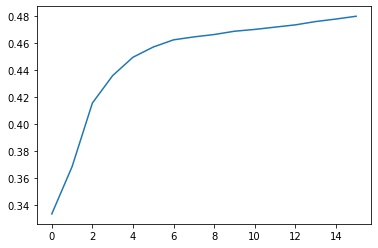

In [14]:
plt.plot(predict_train_var_skl) # This one should be exponential, I cant explain why it isnt. 

# Study irreducible noise

In [39]:
noise = np.random.randn(x.shape[0], x.shape[1]) # normalfordelt støy. 
np.var(Fr(x, y)) # variansen til Fr, kor mykje den er over og under sitt gjennomsnitt. 
# eg skalerer jo data? 
print('Varians lagt til data: ' + str(np.var(noise*np.var(Fr(x, y))*2))) #støy som legges til modellen. Irreducible.
print('Tilsvarer std avvik: ' + str(np.sqrt(np.var(noise*np.var(Fr(x, y))*2))))
# beregnes som gjennomsnittlig (modell - virkelighet) ** 2 
print('Varians i franke: ' + str(np.var(Fr(x, y))))

Varians lagt til data: 0.025513647071256453
Tilsvarer std avvik: 0.15972991914871945
Varians i franke: 0.08214523455598685


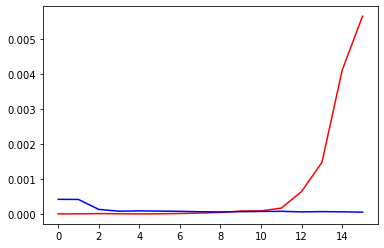

Mean train std: 0.00011707398031042726


In [19]:
plt.plot(test_var, 'r')
plt.plot(train_var, 'b')
plt.show()
print("Mean train std: " + str(np.mean(train_var)))
# Observasjon: gjennomsnittlig avvik i MSE for treningsdata ser ut til å flate ut. 
# Dette setemmer bra overens med det vi observerer i plottet over. Den flater ut omtrent der feilen i test ser ut
# til å begynne å vokse også. 

# Plot and compare beta with results from ex1

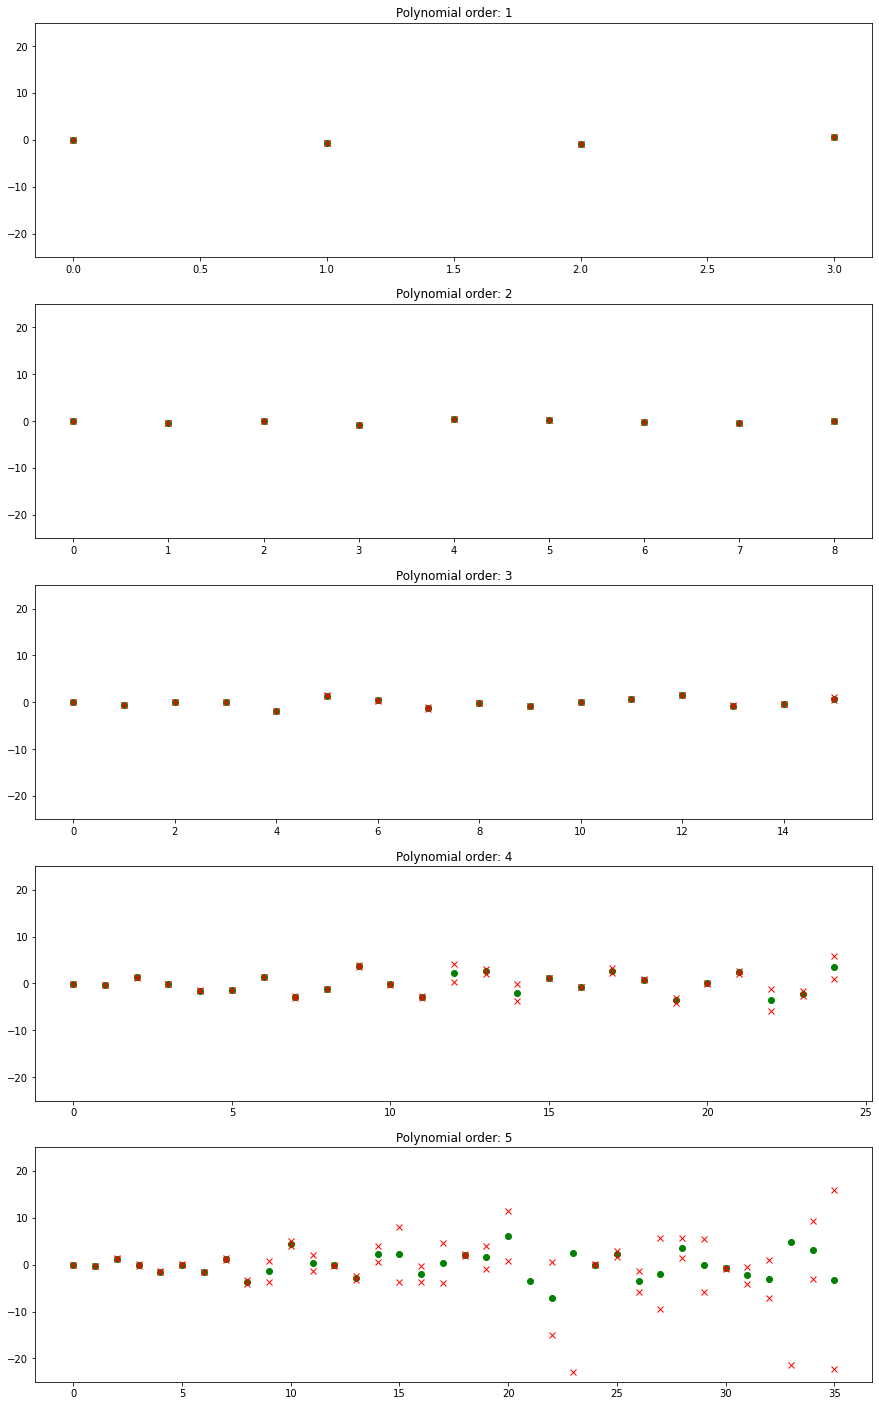

In [163]:
import matplotlib.pyplot as plt
n_polynom = 5 # plot polynoms up to n_polynom order
sigma = 2 # plot two sigma uncertainty
fig, axs = plt.subplots(n_polynom, 1, figsize=(15, 25), facecolor='w', edgecolor='k')
axs = axs.ravel()

sigma = 3
for polynom_nr in range(n_polynom):
    for beta_nr_i in range((polynom_nr+2)**2): # extracts first beta values! 
        axs[polynom_nr].plot(beta_nr_i, mean_betas[polynom_nr][beta_nr_i], 'go') #plot middle beta
        axs[polynom_nr].plot(beta_nr_i, mean_betas[polynom_nr][beta_nr_i] - sigma*var_betas[
            polynom_nr][beta_nr_i], 'rx') #plot middle beta
        axs[polynom_nr].plot(beta_nr_i, mean_betas[polynom_nr][beta_nr_i] + sigma*var_betas[
            polynom_nr][beta_nr_i], 'rx') #plot middle beta

    axs[polynom_nr].set_title('Polynomial order: ' + str(polynom_nr + 1))
    axs[polynom_nr].set_ylim([-25, 25])
plt.show()

In [133]:
# I am able to recover betas, but they differ by sqrt(var_ex 1) !!!! 

# Test and train as function of model complexity

Seed value:  0
Seed value:  1
Seed value:  2
Seed value:  3
Seed value:  4
Seed value:  5
Seed value:  6
Seed value:  7
Seed value:  8
Seed value:  9
Seed value:  10
Seed value:  11


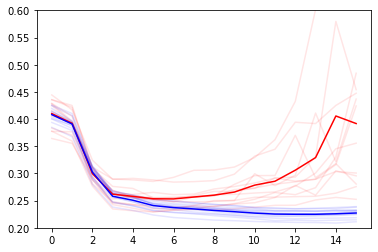

In [125]:
from franke_function import FrankeFunction as Fr
from regression import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 50) # lite: 50, stort: 500
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

poly = 16
MSE_test_list = []
MSE_train_list = []

for n in range(12): #loop thru 15 first seed values
    print("Seed value: ", str(n))
    np.random.seed(n) # Results is highly sensitive to seed choice, for thru different seed values? 
    noise = np.random.randn(x.shape[0], x.shape[1])
    z = Fr(x, y) + noise*np.var(Fr(x, y))*2
    
    scaler = StandardScaler() 
    x_cent = scaler.fit_transform(x.reshape(-1, 1)) #could be done outside loop, here for readability
    y_cent = scaler.fit_transform(y.reshape(-1, 1)) #could be done outside loop, here for readability
    z_cent = scaler.fit_transform(z.reshape(-1, 1))

    xy_cent_train, xy_cent_test, z_cent_train, z_cent_test = train_test_split(np.hstack([x_cent, y_cent]),
                                                                          z_cent, test_size=0.2)
    MSE_test = []
    MSE_train = []
    for poly_deg in range(1, poly + 1):
        model = OLS(xy_cent_train[:, 0].ravel(), xy_cent_train[:, 1].ravel(), z_cent_train.ravel(), poly_deg)
    
        MSE_test.append(model.MSE(xy_cent_test[:, 0], xy_cent_test[:, 1], z_cent_test.ravel()))
        MSE_train.append(model.MSE(xy_cent_train[:, 0], xy_cent_train[:, 1], z_cent_train.ravel())) # orig model.
    
    plt.plot(MSE_test, 'r', alpha=0.1) # test settet gir alltid litt verre estimat ser det ut til
    plt.plot(MSE_train, 'b', alpha=0.1) 
    
    MSE_test_list.append(MSE_test) # sore all values for averaging
    MSE_train_list.append(MSE_train)
    
MSE_test_list = np.array(MSE_test_list)
MSE_train_list = np.array(MSE_train_list)

test_pol_avrg = np.mean(MSE_test_list, axis=0)
train_pol_avrg = np.mean(MSE_train_list, axis=0)

plt.plot(test_pol_avrg, 'r')
plt.plot(train_pol_avrg, 'b')

plt.ylim(0.2, 0.6)
plt.show()
# Observasjonar: 
# Med høyoppløslig grid må eg ha mer støy for at bias variance tradeoff skal oppdages
# Dette kan ha med at med høyoppløslig grid så tvinges funksjonen i større grad å forholde seg til F(x, y)
# , ikkje til støy. (må svinge mykje for å nå alle punkter når dei ligg tettere)Ein kan sjå for seg ein scatter 
#med tett i tett med punkter eller spredde punkter. Dersom  
# pukta ligg tett treng ein meir støy for at polynomet skal over-tilpasse seg. 

In [153]:
x - np.mean(x)

array([[-0.5       , -0.47959184, -0.45918367, ...,  0.45918367,
         0.47959184,  0.5       ],
       [-0.5       , -0.47959184, -0.45918367, ...,  0.45918367,
         0.47959184,  0.5       ],
       [-0.5       , -0.47959184, -0.45918367, ...,  0.45918367,
         0.47959184,  0.5       ],
       ...,
       [-0.5       , -0.47959184, -0.45918367, ...,  0.45918367,
         0.47959184,  0.5       ],
       [-0.5       , -0.47959184, -0.45918367, ...,  0.45918367,
         0.47959184,  0.5       ],
       [-0.5       , -0.47959184, -0.45918367, ...,  0.45918367,
         0.47959184,  0.5       ]])